In [1]:
import dice_ml
import warnings
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay


/home/charles/M2-DAC/.venv/lib/python3.11/site-packages/dice_ml/utils/exception.py:12: UserWarning: UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.
  warnings.warn("UserConfigValidationException will be deprecated from dice_ml.utils. "


In [2]:
X, y = make_moons(
    n_samples=100, noise=0.2, random_state=42
)  # You can adjust the parameters as needed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
df = pd.DataFrame(X, columns=["Feature1", "Feature2"])
df["Target"] = y
df


,Feature1,Feature2,Target
0,1.645654,-0.536487,1
1,0.113649,0.569574,1
2,0.757790,-0.339259,1
3,-1.146562,0.231257,0
4,-0.655267,0.090329,0
...,...,...,...
95,0.177147,-0.195354,1
96,1.096075,-0.561716,1
97,0.476951,0.666176,0
98,1.873825,-0.092585,1


In [3]:
clf = SVC(gamma=1, probability=True)
clf = clf.fit(X_train, y_train)
print(" ### Accuracy:", accuracy_score(y_test, clf.predict(X_test)))


 ### Accuracy: 0.9333333333333333


In [4]:
data = dice_ml.Data(
    dataframe=df, continuous_features=["Feature1", "Feature2"], outcome_name="Target"
)
model = dice_ml.Model(model=clf, backend="sklearn")


In [5]:
explainer = dice_ml.Dice(data, model, method="random")


In [6]:
X_test[0:20]


array([[-0.97130023,  0.4427774 ],
       [ 0.23619118,  0.89304615],
       [ 0.75778982, -0.33925892],
       [ 1.39332049, -0.11720914],
       [-0.02284354, -0.09658796],
       [ 1.38425793, -0.29899479],
       [ 1.15463488, -0.31605304],
       [-0.93066564,  0.07419618],
       [ 0.81422084,  0.70377605],
       [ 0.17714748, -0.19535399],
       [-0.59821541,  0.74256985],
       [ 1.66277215, -0.13653911],
       [ 2.07607826, -0.03114839],
       [-0.67480213,  0.93993138],
       [ 1.4107341 , -0.45469221],
       [ 0.97879136,  0.84922577],
       [ 0.07396121,  0.73311427],
       [ 0.39264481,  0.15026426],
       [-0.1549164 ,  1.36984215],
       [ 0.89497257,  0.745335  ]])

In [7]:
warnings.simplefilter("ignore")
counterfactuals = explainer.generate_counterfactuals(
    query_instances=df.loc[0:1, ["Feature1", "Feature2"]],
    total_CFs=4,
    desired_class="opposite",
    proximity_weight=0.5,
    diversity_weight=1.0,
    features_to_vary="all",
    permitted_range=None,
    posthoc_sparsity_param=0.1,
)


100%|██████████| 2/2 [00:00<00:00, 10.69it/s]


In [8]:
counterfactuals.visualize_as_dataframe()


Query instance (original outcome : 1)


,Feature1,Feature2,Target
0,1.645654,-0.536487,1



Diverse Counterfactual set (new outcome: 0.0)


,Feature1,Feature2,Target
0,1.645654,0.899706,0
1,1.645654,1.359746,0
2,0.824344,1.149777,0
3,-0.893601,0.134433,0


Query instance (original outcome : 0)


,Feature1,Feature2,Target
0,0.113649,0.569574,0



Diverse Counterfactual set (new outcome: 1.0)


,Feature1,Feature2,Target
0,1.725771,0.569574,1
1,0.113649,-0.164346,1
2,0.113649,-0.598549,1
3,0.113649,-0.603410,1


 ### Accuracy: 1.0


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 13.68it/s]


 ### Accuracy: 1.0


100%|██████████| 2/2 [00:00<00:00, 12.81it/s]


 ### Accuracy: 0.9666666666666667


100%|██████████| 2/2 [00:20<00:00, 10.42s/it]


 ### Accuracy: 0.9333333333333333


100%|██████████| 2/2 [00:17<00:00,  8.64s/it]


 ### Accuracy: 0.9


100%|██████████| 2/2 [00:00<00:00, 15.01it/s]


 ### Accuracy: 0.9333333333333333


100%|██████████| 2/2 [00:00<00:00, 13.00it/s]


 ### Accuracy: 1.0


100%|██████████| 2/2 [00:00<00:00, 14.00it/s]


 ### Accuracy: 0.9666666666666667


100%|██████████| 2/2 [00:00<00:00, 13.72it/s]


 ### Accuracy: 0.9333333333333333


100%|██████████| 2/2 [00:00<00:00, 12.75it/s]


 ### Accuracy: 0.8333333333333334


100%|██████████| 2/2 [00:20<00:00, 10.01s/it]


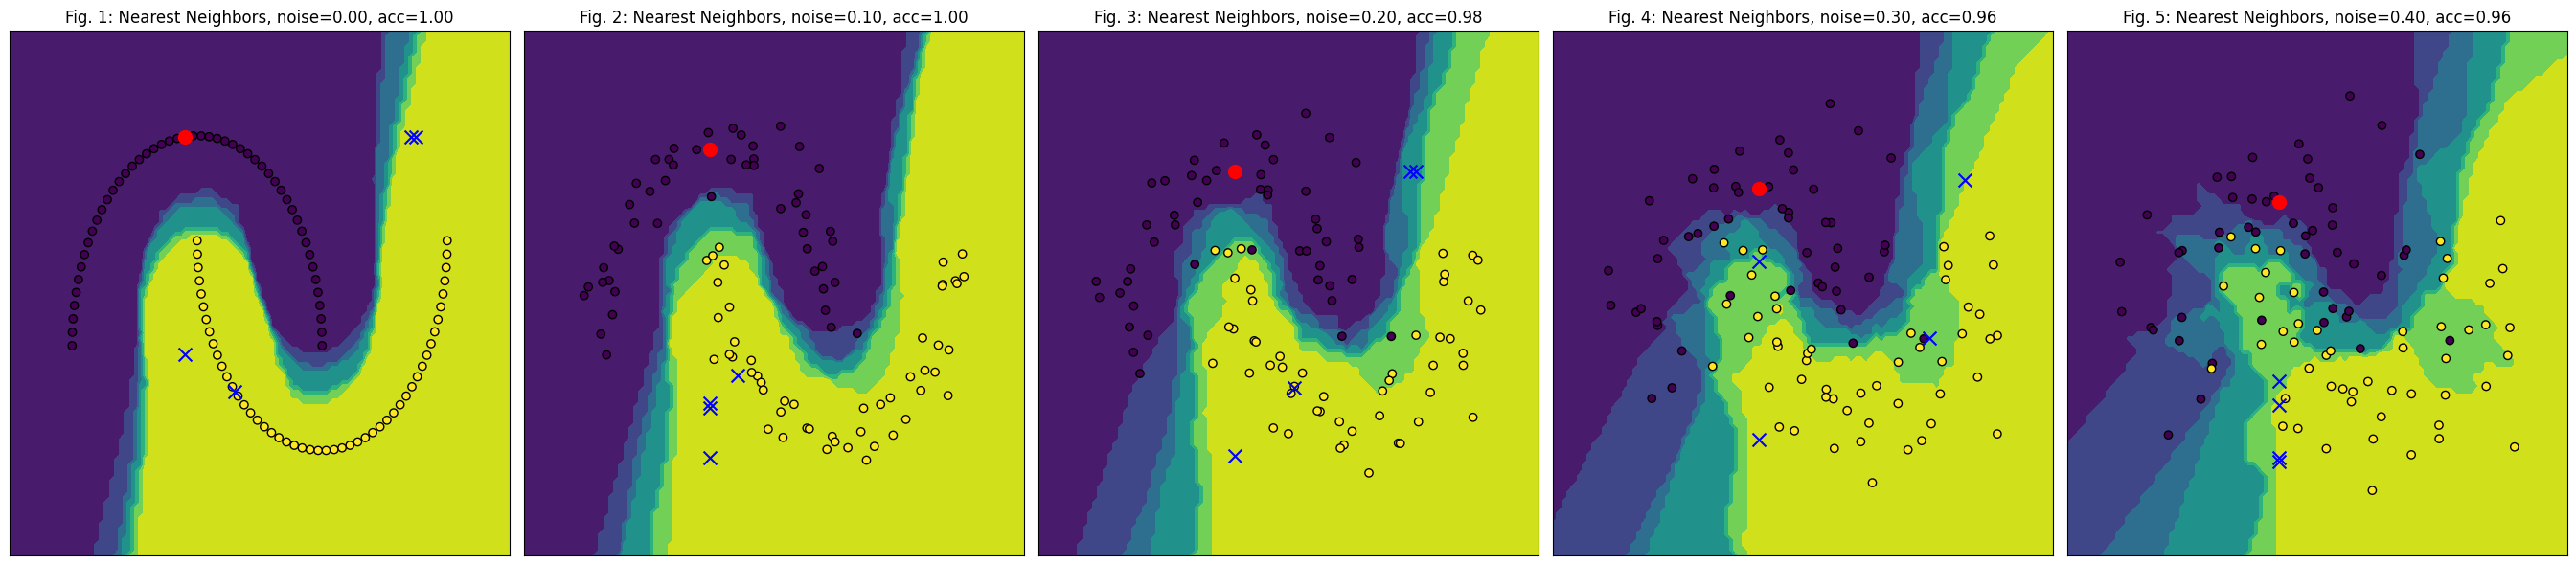

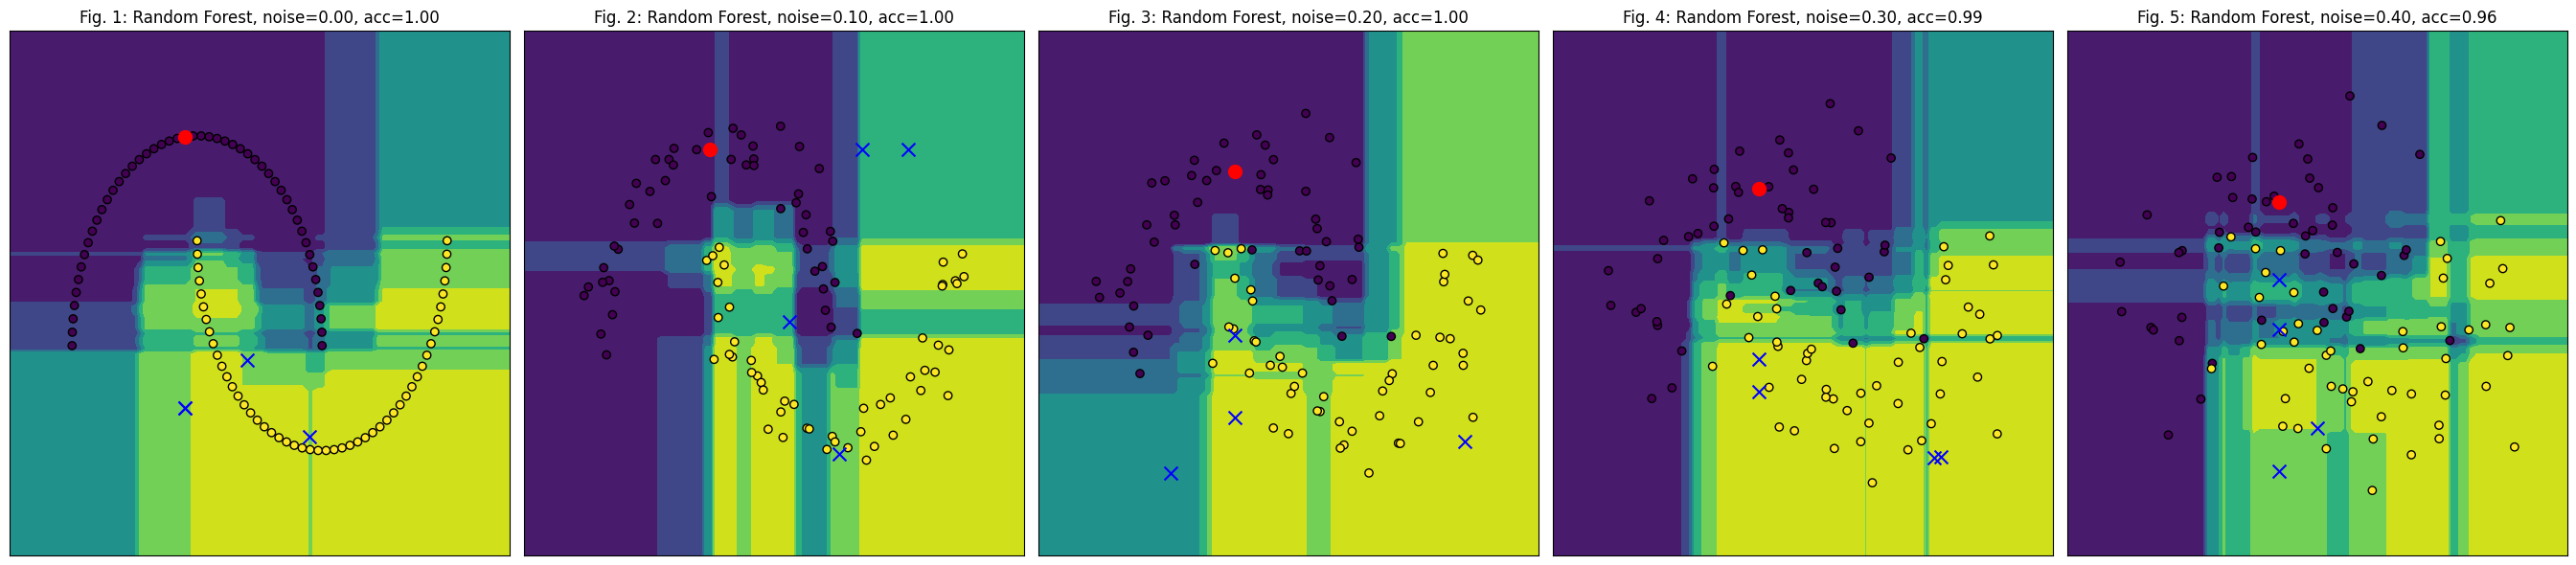

In [9]:
def visualize(
    X,
    y,
    clf,
    backend,
    n=10,
    eta=2,
    n_gs=100,
    ax=None,
):
    def plot_boundaries(X, y, ax, clf):
        """ "Plot the data and the decision boundary resulting from a classifier."""
        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        DecisionBoundaryDisplay.from_estimator(clf, X, ax=ax, eps=0.5)
        # Plot the training points
        ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k")
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=0
    )
    df = pd.DataFrame(X, columns=["Feature1", "Feature2"])
    df["Target"] = y

    clf = clf.fit(X_train, y_train)
    print(" ### Accuracy:", accuracy_score(y_test, clf.predict(X_test)))

    data = dice_ml.Data(
        dataframe=df,
        continuous_features=["Feature1", "Feature2"],
        outcome_name="Target",
    )
    model = dice_ml.Model(model=clf, backend=backend)
    if backend == "sklearn":
        explainer = dice_ml.Dice(data, model, method="random")
    else:
        explainer = dice_ml.Dice(data, model)

    warnings.simplefilter("ignore")
    counterfactuals = explainer.generate_counterfactuals(
        query_instances=df.loc[0:1, ["Feature1", "Feature2"]],
        total_CFs=4,
        desired_class="opposite",
        proximity_weight=0.5,
        diversity_weight=1.0,
        features_to_vary="all",
        permitted_range=None,
        posthoc_sparsity_param=0.1,
    )

    if not ax:
        _, ax = plt.subplots()
    plot_boundaries(X, y, ax, clf)
    ax.scatter(
        df.loc[0, ["Feature1"]],
        df.loc[0, "Feature2"],
        c="red",
        marker="o",
        label="Obs",
        s=100,
    )
    enemy_df = counterfactuals.cf_examples_list[0].final_cfs_df
    ax.scatter(enemy_df["Feature1"], enemy_df["Feature2"], c="blue", marker="x", s=100)

    return ax


names = [
    "Nearest Neighbors",
    "Random Forest",
    "SVM",
]
classifiers = [
    KNeighborsClassifier(),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    # SVC(),
]

## Création de jeux de données avec différents niveaux de bruit
datasets = []
noise_lvl = []
for noise in np.arange(0, 0.5, 0.1):
    noise_lvl.append(noise)
    datasets.append(make_moons(noise=noise, random_state=0))

for clf, name in zip(classifiers, names):
    fig = plt.figure(figsize=(27, 6))
    for i, (dataset, noise) in enumerate(zip(datasets, noise_lvl)):
        X, y = dataset
        clf = clf.fit(X, y)
        ax = fig.add_subplot(1, len(datasets), i + 1)
        ax.set_title(
            f"Fig. {i+1}: {name}, noise={noise:.2f}, acc={accuracy_score(y, clf.predict(X)):.2f}"
        )
        visualize(X, y, clf, "sklearn", ax=ax)
    fig.tight_layout()


**Faire varier les paramètre de DICE**


# Pytorch


In [70]:
from typing import Any
import torch
import torch.nn as nn
import torch.optim as optim


class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 16)  # 2 input features, 16 hidden units
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 1)  # 1 output unit (binary classification)
        self.sig = nn.Sigmoid()

    def __call__(self, *args: Any, **kwds: Any) -> Any:
        return self.forward(*args, **kwds)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sig(x)
        return x

    def reset(self):
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()


# Generate synthetic data
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)


In [75]:
def plot_boundaries_torch(X, y, ax, model):
    """ "Plot the data and the decision boundary resulting from a classifier."""
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    step = 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    grid = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])

    with torch.no_grad():
        Z = model(grid).numpy()
    Z = Z.reshape(xx.shape)

    # Plot the training points
    ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)
    # ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k")
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu, edgecolors="k")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())


def train_torch_model(X_train, X_test, y_train, y_test, model, force=False):
    # Create the model
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss
    optimizer = optim.Adam(model.parameters(), lr=0.005)

    num_epochs = 2000

    for epoch in range(num_epochs):
        inputs = torch.tensor(X_train, dtype=torch.float32)
        labels = torch.tensor(y_train, dtype=torch.float32).unsqueeze(
            1
        )  # Add a dimension for the output

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if (epoch + 1) % 100 == 0:
        #     print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    print("Training complete")

    model.eval()  # Set the model to evaluation mode
    test_inputs = torch.tensor(X_test, dtype=torch.float32)
    with torch.no_grad():
        test_outputs = model(test_inputs)
        predicted_labels = np.round(test_outputs)

    accuracy = (predicted_labels.detach().numpy() == y_test.reshape(-1, 1)).mean()
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    if force and accuracy != 1:
        print(accuracy)
        print("Force = True, forcing train till good accuracy")
        model.reset()
        train_torch_model(X_train, X_test, y_train, y_test, model, force=True)


def gen_counterfactuals(df, model,
        total_CFs=4,
        desired_class="opposite",
        proximity_weight=0.5,
        diversity_weight=1.0,
        features_to_vary="all",
        sparsity_weight=0.2,
        permitted_range=None,
        posthoc_sparsity_param=0.1):
    data = dice_ml.Data(
        dataframe=df,
        continuous_features=["Feature1", "Feature2"],
        outcome_name="Target",
    )
    dice_model = dice_ml.Model(model=model, backend="PYT")
    explainer = dice_ml.Dice(data, dice_model)

    warnings.simplefilter("ignore")
    counterfactuals = explainer.generate_counterfactuals(
        query_instances=df.loc[0:1, ["Feature1", "Feature2"]],
        total_CFs=total_CFs,
        desired_class=desired_class,
        proximity_weight=proximity_weight,
        diversity_weight=diversity_weight,
        features_to_vary=features_to_vary,
        sparsity_weight=sparsity_weight,
        permitted_range=permitted_range,
        posthoc_sparsity_param=posthoc_sparsity_param,
    )
    enemy_df = counterfactuals.cf_examples_list[0].final_cfs_df
    return enemy_df


def gen_data(X, y):
    df = pd.DataFrame(X, columns=["Feature1", "Feature2"])
    df["Target"] = y

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    return df, X_train, X_test, y_train, y_test


def visualizePytorch(
    X,
    y,
    enemy_df,
    model,
    ax=None,
):
    if not ax:
        _, ax = plt.subplots()
    plot_boundaries_torch(X, y, ax, model)
    ax.scatter(
        df.loc[0, ["Feature1"]],
        df.loc[0, "Feature2"],
        c="red",
        marker="o",
        label="Obs",
        s=100,
    )
    ax.scatter(enemy_df["Feature1"], enemy_df["Feature2"], c="blue", marker="x", s=100)
    return ax


Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 16.19it/s]


Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 15.79it/s]


Training complete
Test Accuracy: 95.00%


  0%|          | 0/2 [00:09<?, ?it/s]


KeyboardInterrupt: 

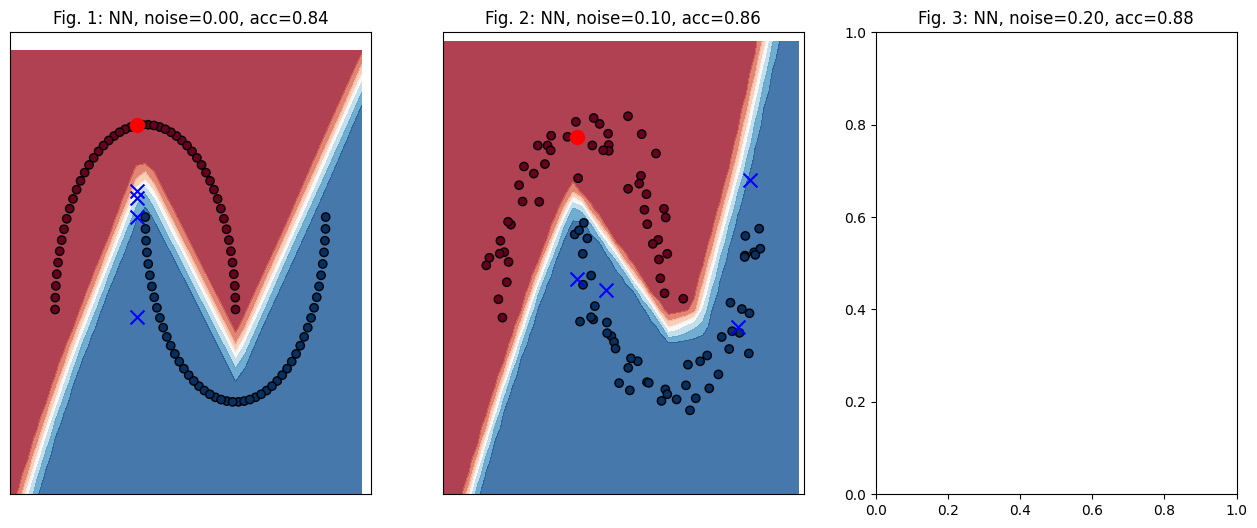

In [68]:
fig = plt.figure(figsize=(27, 6))

for i, (dataset, noise) in enumerate(zip(datasets, noise_lvl)):
    X, y = dataset
    ax = fig.add_subplot(1, len(datasets), i + 1)
    ax.set_title(
        f"Fig. {i+1}: NN, noise={noise:.2f}, acc={accuracy_score(y, clf.predict(X)):.2f}"
    )

    df, X_train, X_test, y_train, y_test = gen_data(X, y)
    model = SimpleNN()
    train_torch_model(X_train, X_test, y_train, y_test, model)
    enemy_df = gen_counterfactuals(df, model)
    visualizePytorch(X, y, enemy_df, model, ax=ax)
fig.tight_layout()


# Validation des exemples contrefactuels générés


Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 15.42it/s]


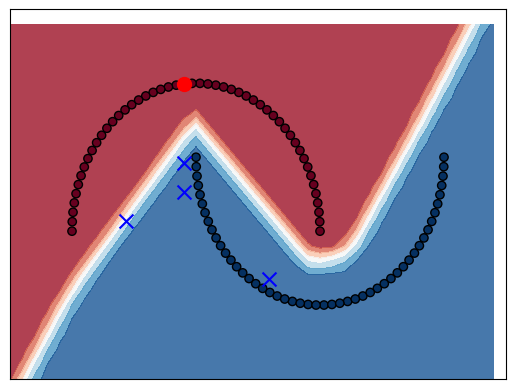

In [13]:
X, y = datasets[0]
model = SimpleNN()
df, X_train, X_test, y_train, y_test = gen_data(X, y)
train_torch_model(X_train, X_test, y_train, y_test, model)
enemy_df = gen_counterfactuals(df, model)
visualizePytorch(X, y, enemy_df, model)
obs_to_interprete = df.loc[0, ["Feature1", "Feature2"]]
target = df.loc[0, ["Target"]]


## Validité


In [14]:
def check_validity(enemy_df: pd.DataFrame, original_target: int):
    return np.where(enemy_df["Target"].values != original_target.values, True, False)


In [15]:
check_validity(enemy_df, target)


array([ True,  True,  True,  True])

## Proximité


In [16]:
def compute_distances(enemy_df: pd.DataFrame, target: pd.DataFrame):
    """Compite

    Parameters
    ----------
    enemy_df : _type_
        _description_
    target : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    return np.linalg.norm(
        enemy_df.drop(columns="Target").values - target.values, axis=1
    )


In [17]:
compute_distances(enemy_df, obs_to_interprete)


array([1.03449067, 0.53260658, 1.48150847, 0.72916115])

## Parcimony


In [18]:
def mesure_parcimony(enemy_df: pd.DataFrame, target: pd.DataFrame):
    return np.linalg.norm(
        enemy_df.drop(columns="Target").values - target.values, axis=1, ord=0
    )  # non zero elemt


In [19]:
mesure_parcimony(enemy_df, obs_to_interprete)


array([2., 1., 2., 1.])

# Experiments


## Stabilité


Training complete
Test Accuracy: 85.00%
0.85
Force = True, forcing train till good accuracy
Training complete
Test Accuracy: 85.00%
0.85
Force = True, forcing train till good accuracy
Training complete
Test Accuracy: 85.00%
0.85
Force = True, forcing train till good accuracy
Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:12<00:00,  6.06s/it]


(array([[1.19694479, 0.43022543, 1.01863689, 1.07603177],
        [2.12875879, 1.08400662, 1.93784769, 1.46001504],
        [1.15447247, 1.11285467, 0.83580803, 1.06687613],
        [1.84291515, 1.004325  , 1.97121983, 1.79302963],
        [0.93368585, 1.23951696, 0.69485648, 1.13546161],
        [0.80012758, 1.45779812, 0.73037397, 1.4286494 ],
        [1.3405544 , 1.25681376, 2.19829674, 0.83565059],
        [0.47527985, 0.39099587, 1.38307278, 1.3692095 ],
        [1.43175556, 0.50222325, 0.39564559, 1.28927893],
        [1.19083562, 1.06108441, 1.27232799, 1.98291307],
        [0.90221541, 0.72597299, 1.32944365, 1.27299011],
        [2.11631561, 0.66882522, 1.38803806, 1.23878248],
        [0.92776542, 1.45349687, 0.37280073, 0.67262122],
        [1.07686611, 0.92853467, 1.13660441, 1.02198383],
        [1.4603009 , 0.54025833, 0.50642747, 0.58364531],
        [1.18409789, 1.18022269, 0.41320279, 1.00202239],
        [0.72838244, 1.51368815, 1.39408577, 1.02080462],
        [2.332

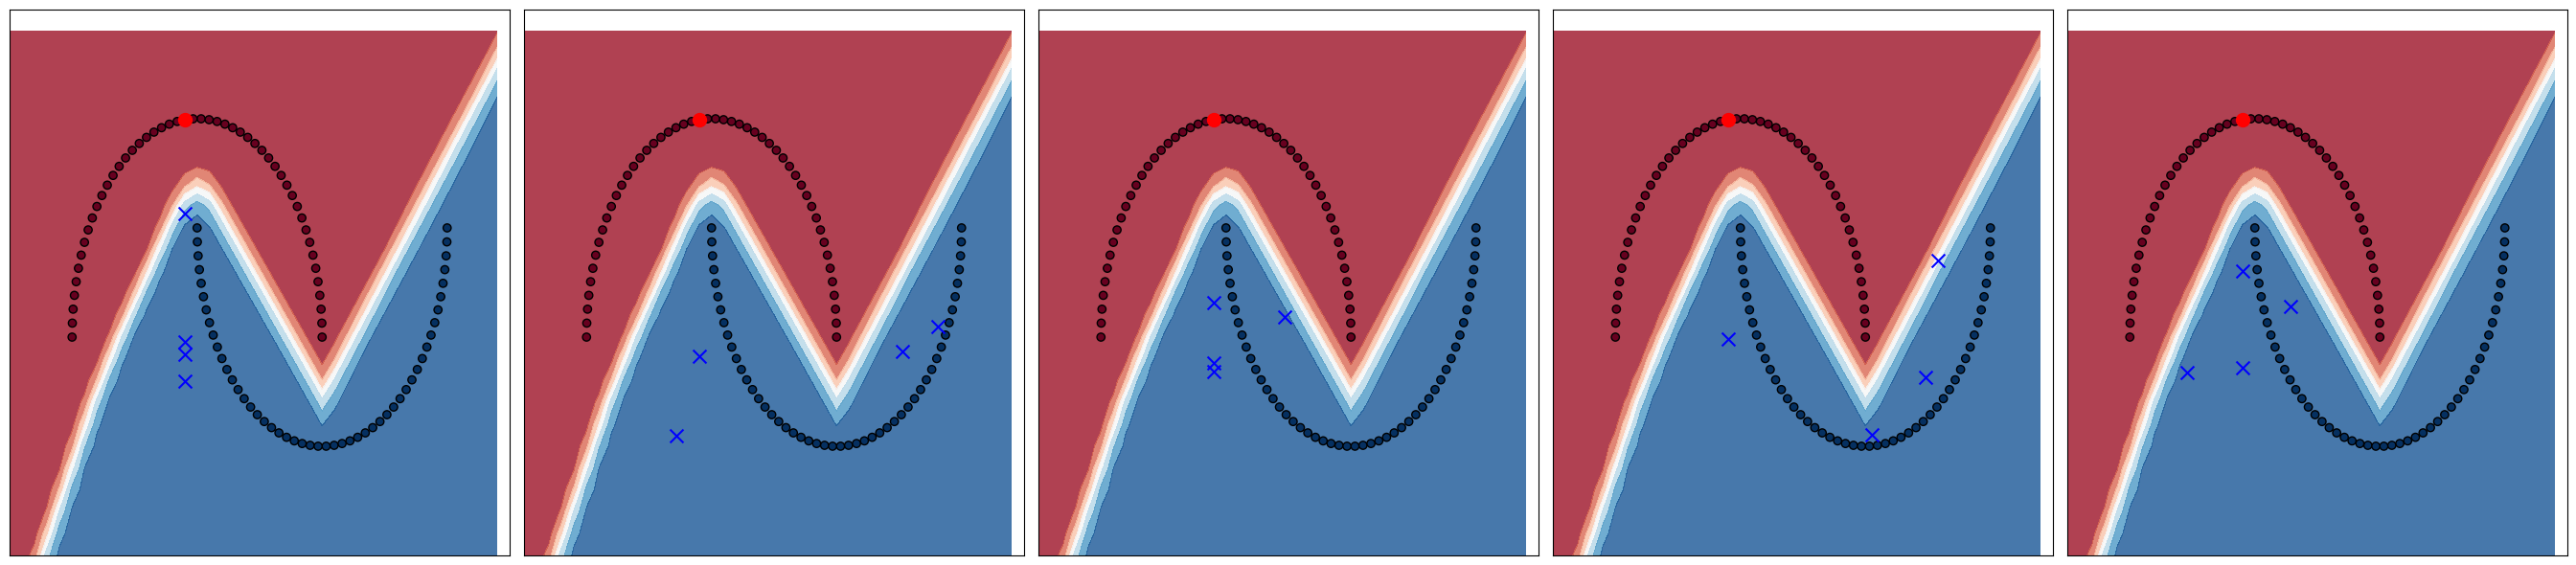

In [77]:
distance_list = []
mesure_parcimony_list = []
fig = plt.figure(figsize=(27, 6))
model = SimpleNN()
df, X_train, X_test, y_train, y_test = gen_data(X, y)
train_torch_model(X_train, X_test, y_train, y_test, model, force=True)

obs_to_interprete = df.loc[0, ["Feature1", "Feature2"]]
target = df.loc[0, ["Target"]]

for i in range(20):
    X, y = datasets[0]

    # generate new enemies
    enemy_df = gen_counterfactuals(df, model)
    if i < 5:
        ax = fig.add_subplot(1, len(datasets), i + 1)
        visualizePytorch(X, y, enemy_df, model, ax=ax)

    valids = check_validity(enemy_df, target)
    if not valids.all():
        print("Experiment {i} : Some enemies are not valid")
        print(enemy_df)

    distance_list.append(compute_distances(enemy_df, obs_to_interprete))
    mesure_parcimony_list.append(mesure_parcimony(enemy_df, obs_to_interprete))

distance_list = np.array(distance_list)
mesure_parcimony_list = np.array(mesure_parcimony_list)
fig.tight_layout()
distance_list, mesure_parcimony_list


Dans cette expérience, nous souhaitons tester la stabilité des exemples généré par DICE. Nous allons observer la validité, la distance et la parcimonie sur n=20 run de DICE qui génère chacune 5 exemples contrefactuels.

Premièrement sur n=20 run de DICE, aucun des 5\*20 exemples contrefactuel généré a été invalide, c'est à dire prédit de la même classe que l'observation à expliquer.

Pour évaluer la distance, supposont que chacun des 20 échantillons suivent chacun une gaussienne de moyenne inconnus mais de même variance (homoscédasticité). Testons si il ont tous été généré avec la même moyenne par un test d'ANOVA


In [21]:
import scipy.stats as stats

stats.f_oneway(*distance_list)


F_onewayResult(statistic=0.8154756902603001, pvalue=0.6806439064062602)

La p-value est élevé, on conserve l'hypothèse nul disant qu'il n'y a pas de différence entre les groupes, DICE serait donc stable dans la généréation de ces enemies

Faisons la même chose pour la parcimonies


In [22]:
stats.f_oneway(*mesure_parcimony_list)


F_onewayResult(statistic=0.5915161036920662, pvalue=0.8979384643604273)

---


Rapide test avec un nouveau réseau à chaque itération


Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 10.02it/s]


Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:12<00:00,  6.39s/it]


Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 17.17it/s]


Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:14<00:00,  7.15s/it]


Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 15.98it/s]


Training complete
Test Accuracy: 85.00%


100%|██████████| 2/2 [00:00<00:00, 18.74it/s]


Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 18.69it/s]


Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 18.50it/s]


Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 14.33it/s]


Training complete
Test Accuracy: 95.00%


100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:09<00:00,  4.69s/it]


Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 14.37it/s]


Training complete
Test Accuracy: 85.00%


100%|██████████| 2/2 [00:00<00:00, 13.94it/s]


Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 18.38it/s]


Training complete
Test Accuracy: 85.00%


100%|██████████| 2/2 [00:00<00:00, 19.20it/s]


Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 16.72it/s]


Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:11<00:00,  5.78s/it]


Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:23<00:00, 11.86s/it]


Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 11.93it/s]


Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 10.97it/s]


([array([0.42915374, 1.48660168, 0.74180451, 0.77135051]),
  array([1.50454141, 2.37298885, 2.08633105, 2.33336957]),
  array([1.90382704, 1.48004057, 0.54285827, 1.93827231]),
  array([1.49323132, 1.83733715, 1.28158445, 1.92079224]),
  array([0.79309839, 0.75601928, 0.50576453, 0.92450338]),
  array([1.14706686, 2.0539712 , 2.24873806, 0.90884972]),
  array([1.47527617, 1.10601302, 0.61210135, 0.52557389]),
  array([0.53027956, 1.05657885, 0.43040708, 1.39413189]),
  array([1.35070077, 0.71918577, 0.5188527 , 0.35395826]),
  array([1.43871545, 1.30729724, 1.29957628, 1.37588794]),
  array([1.20544789, 1.00896809, 1.14475457, 0.93066231]),
  array([1.44763251, 1.23799989, 2.18102852, 0.45378176]),
  array([1.47102805, 1.28731824, 1.49696126, 0.90129769]),
  array([1.02254757, 2.48816581, 1.4419882 , 0.92980574]),
  array([0.82626101, 1.4763203 , 1.19630521, 1.18612877]),
  array([0.86830144, 1.47412099, 0.33535869, 0.48149464]),
  array([0.78238644, 1.09981624, 2.33573052, 1.33106417]

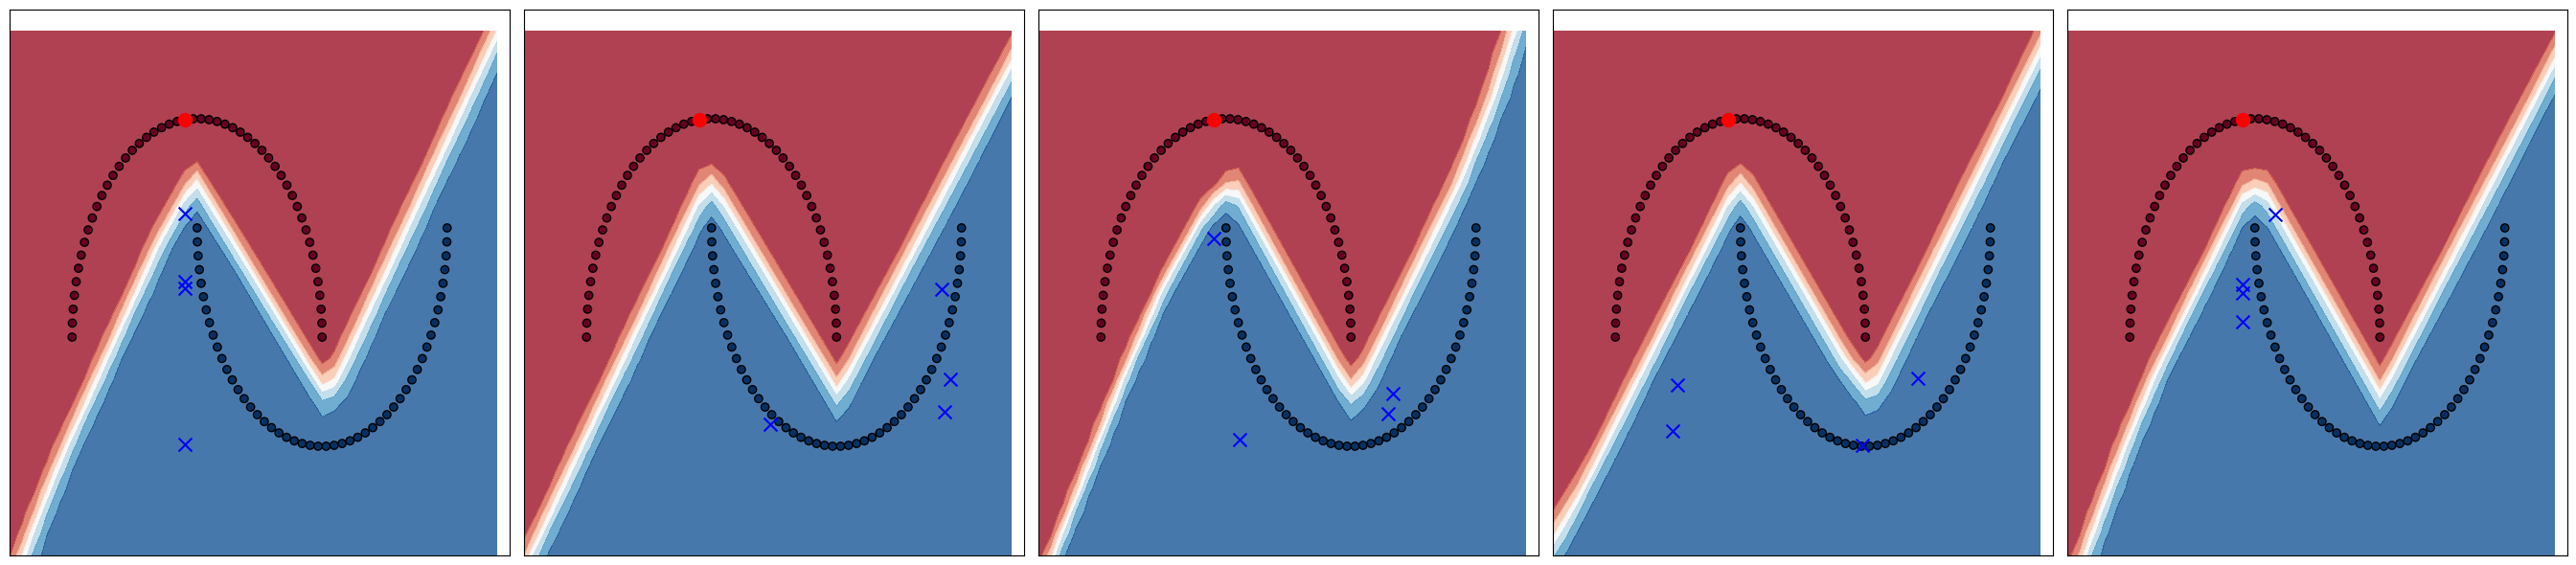

In [50]:
distance_list_retrain = []
mesure_parcimony_list_retrain = []
fig = plt.figure(figsize=(27, 6))

obs_to_interprete = df.loc[0, ["Feature1", "Feature2"]]
target = df.loc[0, ["Target"]]
X, y = datasets[0]
df, X_train, X_test, y_train, y_test = gen_data(X, y)

for i in range(20):
    model = SimpleNN()
    train_torch_model(X_train, X_test, y_train, y_test, model, force=True)

    # generate new enemies
    enemy_df = gen_counterfactuals(df, model)
    if i < 5:
        ax = fig.add_subplot(1, len(datasets), i + 1)
        visualizePytorch(X, y, enemy_df, model, ax=ax)

    valids = check_validity(enemy_df, target)
    if not valids.all():
        print("Experiment {i} : Some enemies are not valid")
        print(enemy_df)

    distance_list_retrain.append(compute_distances(enemy_df, obs_to_interprete))
    mesure_parcimony_list_retrain.append(mesure_parcimony(enemy_df, obs_to_interprete))

fig.tight_layout()
distance_list_retrain, mesure_parcimony_list_retrain


In [26]:
stats.f_oneway(*distance_list_retrain), stats.f_oneway(*mesure_parcimony_list_retrain)


(F_onewayResult(statistic=1.0282451455554213, pvalue=0.4446696659653317),
 F_onewayResult(statistic=1.1542649727767693, pvalue=0.3256705394924196))

---


## Variation des paramètres de DICE


- **total_CFs** – Total number of counterfactuals required.
- **desired_class** – Desired counterfactual class - can take 0 or 1. Default value is “opposite” to the outcome class of query_instance for binary classification.
- **desired_range** – For regression problems. Contains the outcome range to generate counterfactuals in. This should be a list of two numbers in ascending order.
- **permitted_range** – Dictionary with feature names as keys and permitted range in list as values. Defaults to the range inferred from training data. If None, uses the parameters initialized in data_interface.

- **features_to_vary** – Either a string “all” or a list of feature names to vary.
- **stopping_threshold** – Minimum threshold for counterfactuals target class probability.
- **proximity_weight** – A positive float. Larger this weight, more close the counterfactuals are to the query_instance. Used by [‘genetic’, ‘gradientdescent’], ignored by [‘random’, ‘kdtree’] methods.
- **sparsity_weight** – A positive float. Larger this weight, less features are changed from the query_instance. Used by [‘genetic’, ‘kdtree’], ignored by [‘random’, ‘gradientdescent’] methods.
- **diversity_weight** – A positive float. Larger this weight, more diverse the counterfactuals are. Used by [‘genetic’, ‘gradientdescent’], ignored by [‘random’, ‘kdtree’] methods.
- **categorical_penalty** – A positive float. A weight to ensure that all levels of a categorical variable sums to 1. Used by [‘genetic’, ‘gradientdescent’], ignored by [‘random’, ‘kdtree’] methods.
- **posthoc_sparsity_param** – Parameter for the post-hoc operation on continuous features to enhance sparsity.
- **posthoc_sparsity_algorithm** – Perform either linear or binary search. Takes “linear” or “binary”. Prefer binary search when a feature range is large (for instance, income varying from 10k to 1000k) and only if the features share a monotonic relationship with predicted outcome in the model.


### Proximité


Training complete
Test Accuracy: 100.00%
Force = True, forcing train till good accuracy
Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 12.95it/s]


array([[2.20584778, 2.07940744, 1.89648108, 0.41652374],
       [1.33639195, 0.60951529, 1.29853391, 0.68935787],
       [1.44047419, 1.18540151, 1.14502267, 0.90110221],
       [1.19843617, 0.89307027, 1.14227238, 1.41019617],
       [1.40924489, 0.9667464 , 1.33392348, 0.50771298],
       [0.35011178, 1.86257706, 2.17309437, 1.44942212],
       [0.95324467, 1.00766203, 0.8635081 , 1.07301852],
       [0.82230453, 1.8005212 , 1.45476211, 0.52612546],
       [1.30577148, 1.39015721, 0.40443507, 0.50493006],
       [1.27732277, 1.09519178, 0.40193772, 1.51898964],
       [0.49558752, 0.50849642, 1.10797567, 0.54322629],
       [0.63336026, 1.57467046, 0.70596825, 0.4143905 ],
       [0.64930833, 0.908559  , 1.30725312, 0.41941249],
       [0.56586249, 0.45450157, 0.41950976, 2.11153884],
       [1.27555661, 0.64137304, 0.52841879, 0.91655572],
       [1.158232  , 1.10385603, 1.28683105, 2.17266513],
       [1.23763388, 1.02860502, 1.96032127, 0.82467935],
       [1.05854819, 0.49601674,

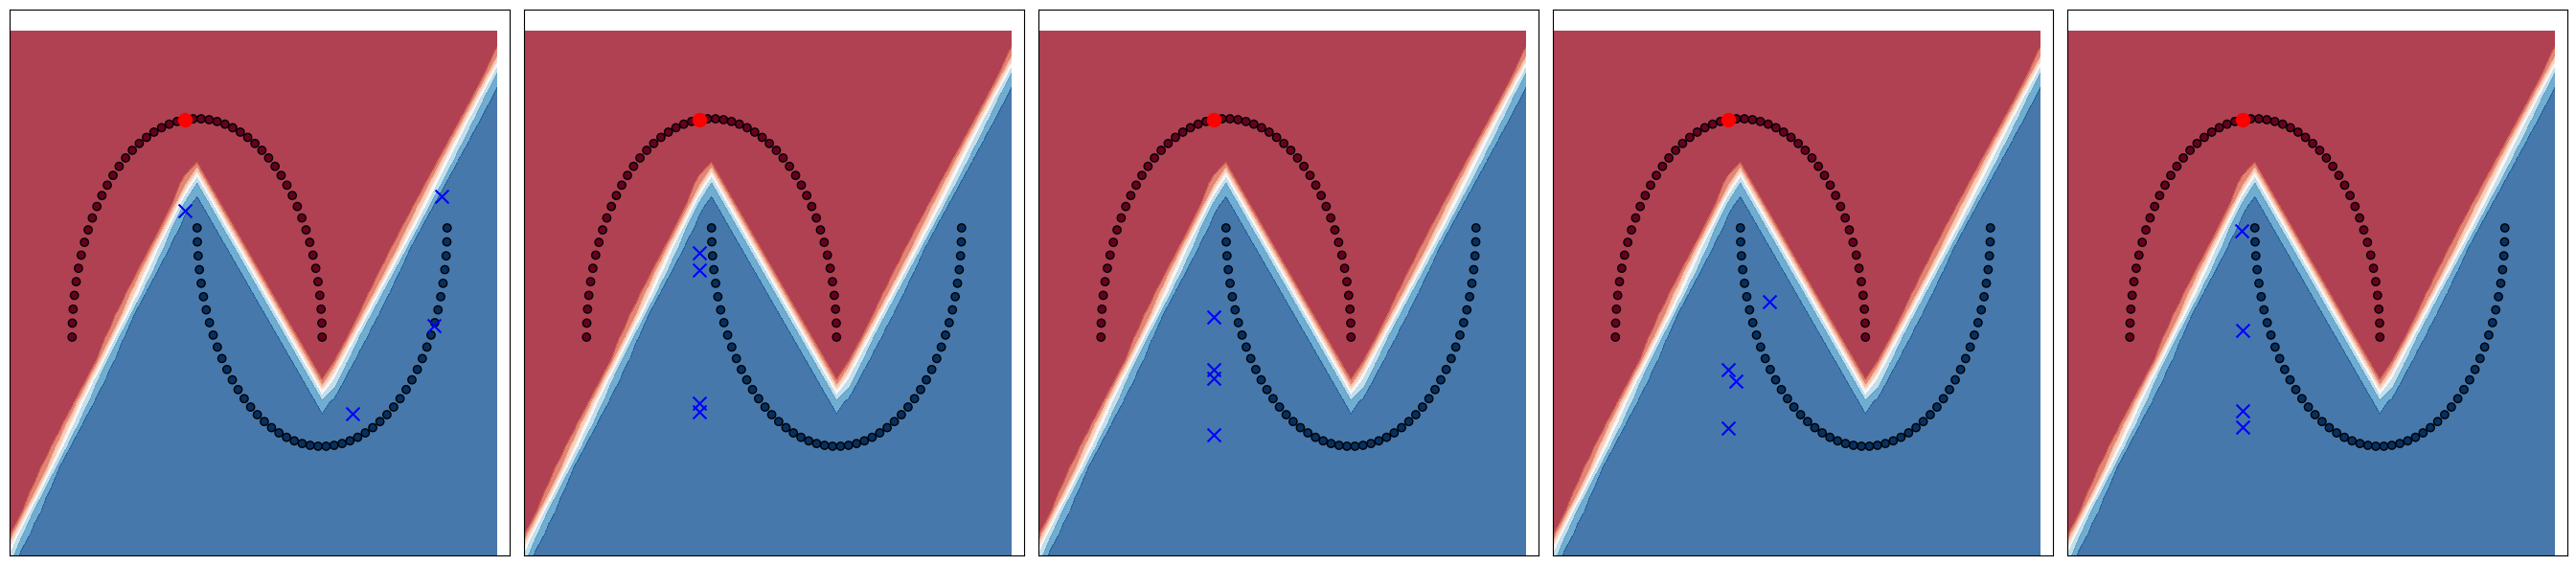

In [54]:
distance_list_new_parameter = []
fig = plt.figure(figsize=(27, 6))
model = SimpleNN()
df, X_train, X_test, y_train, y_test = gen_data(X, y)
train_torch_model(X_train, X_test, y_train, y_test, model, force=True)

obs_to_interprete = df.loc[0, ["Feature1", "Feature2"]]
target = df.loc[0, ["Target"]]

for i in range(20):
    X, y = datasets[0]

    # generate new enemies
    enemy_df = gen_counterfactuals(df, model, proximity_weight=0.8)
    if i < 5:
        ax = fig.add_subplot(1, len(datasets), i + 1)
        visualizePytorch(X, y, enemy_df, model, ax=ax)

    valids = check_validity(enemy_df, target)
    if not valids.all():
        print("Experiment {i} : Some enemies are not valid")
        print(enemy_df)

    distance_list_new_parameter.append(compute_distances(enemy_df, obs_to_interprete))
distance_list_new_parameter = np.array(distance_list_new_parameter)
fig.tight_layout()
distance_list_new_parameter


Utilisons un test t-test pour voir si changer le paramètre de la distance à effectivement un impact. On suppose la même variance


In [63]:
stats.ttest_ind(distance_list.mean(axis=1), distance_list_new_parameter.mean(1))

TtestResult(statistic=4.25249827780218, pvalue=0.00013257366310928269, df=38.0)

In [64]:
stats.ttest_ind(distance_list.mean(axis=1), distance_list_new_parameter.mean(1), equal_var=False)

TtestResult(statistic=4.2524982778021805, pvalue=0.00013821852501069687, df=36.9138393032263)

Le paramètre fonctionne bien, les deux jeux de distance moyennes n'aurai pas la bonne moyenne avec p<0.01


### Parcimonie


Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 14.06it/s]


array([[2., 1., 1., 1.],
       [2., 1., 1., 2.],
       [1., 1., 2., 2.],
       [1., 1., 1., 1.],
       [2., 1., 2., 1.],
       [2., 1., 2., 1.],
       [1., 2., 1., 1.],
       [1., 1., 1., 2.],
       [2., 2., 2., 1.],
       [2., 2., 2., 1.],
       [1., 1., 1., 1.],
       [1., 2., 2., 1.],
       [1., 2., 1., 2.],
       [1., 1., 2., 2.],
       [2., 1., 1., 1.],
       [1., 1., 1., 1.],
       [2., 1., 1., 1.],
       [1., 1., 2., 2.],
       [1., 2., 2., 1.],
       [1., 1., 1., 2.]])

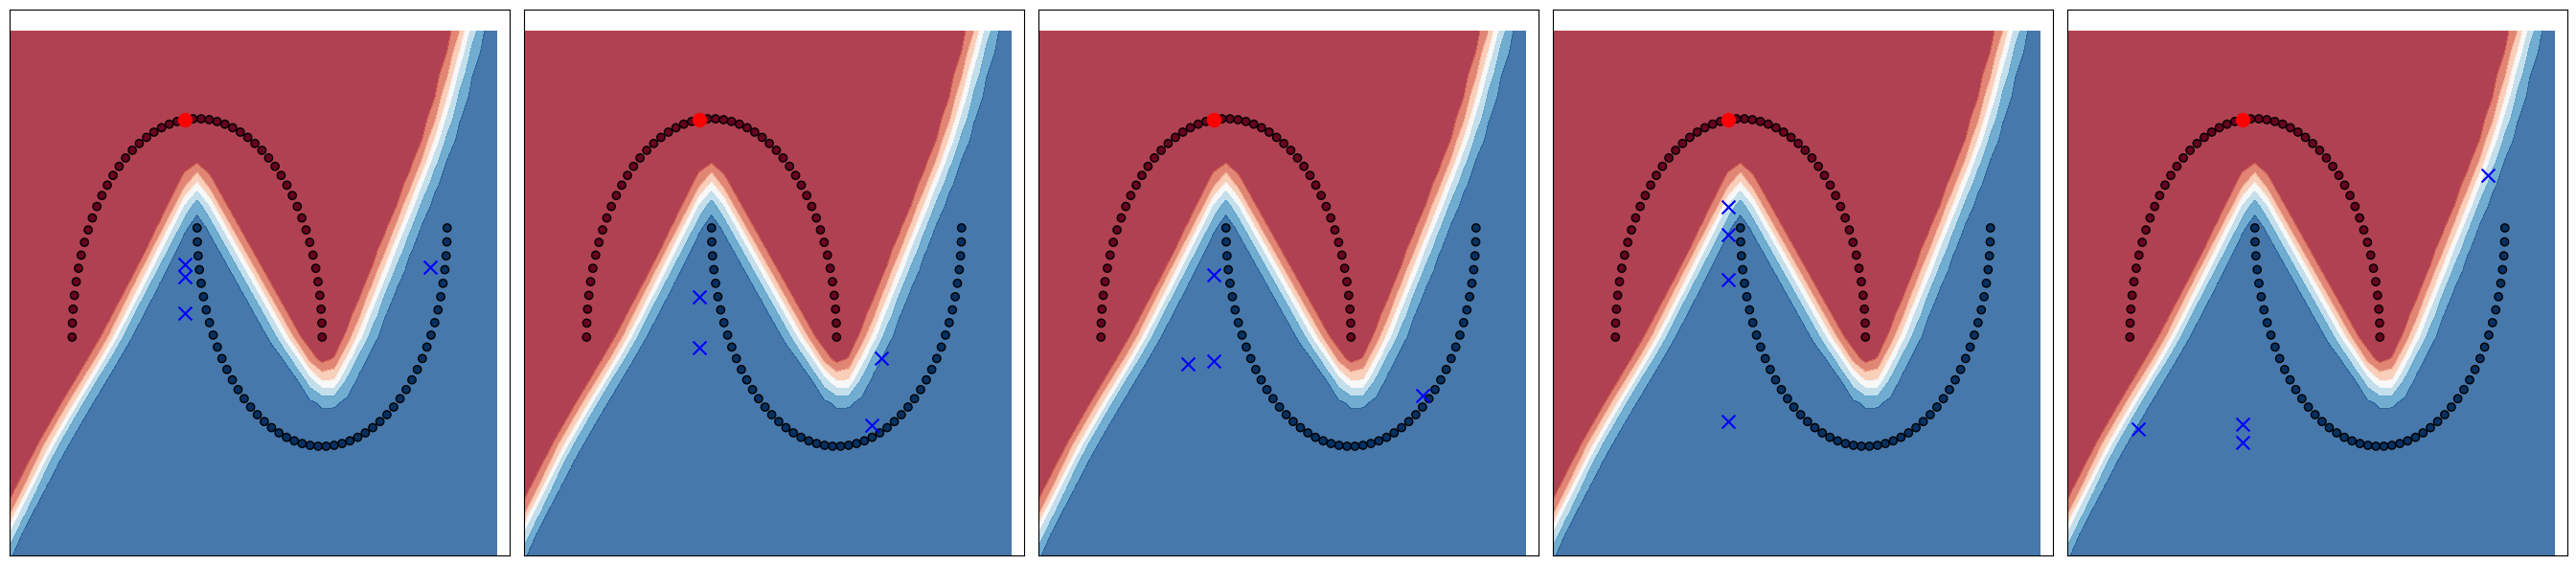

In [78]:
mesure_parcimony_list_new_parameter = []
fig = plt.figure(figsize=(27, 6))
model = SimpleNN()
df, X_train, X_test, y_train, y_test = gen_data(X, y)
train_torch_model(X_train, X_test, y_train, y_test, model, force=True)

obs_to_interprete = df.loc[0, ["Feature1", "Feature2"]]
target = df.loc[0, ["Target"]]

for i in range(20):
    X, y = datasets[0]

    # generate new enemies
    enemy_df = gen_counterfactuals(df, model, sparsity_weight=0.8)
    if i < 5:
        ax = fig.add_subplot(1, len(datasets), i + 1)
        visualizePytorch(X, y, enemy_df, model, ax=ax)

    valids = check_validity(enemy_df, target)
    if not valids.all():
        print("Experiment {i} : Some enemies are not valid")
        print(enemy_df)

    mesure_parcimony_list_new_parameter.append(mesure_parcimony(enemy_df, obs_to_interprete))
mesure_parcimony_list_new_parameter = np.array(mesure_parcimony_list_new_parameter)
fig.tight_layout()
mesure_parcimony_list_new_parameter


Il existe peut être un test plus adapté mais je n'en ai pas trouvé un vraiment adapté


In [80]:
stats.ttest_ind(mesure_parcimony_list.mean(axis=1), mesure_parcimony_list_new_parameter.mean(1))

TtestResult(statistic=0.46495381280343984, pvalue=0.6446179461767563, df=38.0)

En agrégeant en comptant le nombre de 1 et ignorant les 2


In [82]:
stats.ttest_ind(np.where(mesure_parcimony_list==1, 1, 0).sum(1), np.where(mesure_parcimony_list_new_parameter==1, 1, 0).sum(1))

TtestResult(statistic=-0.4649538128034384, pvalue=0.6446179461767574, df=38.0)

Observont en comptant simplement à la main


In [92]:
pd.Series(mesure_parcimony_list.flatten()).value_counts(), pd.Series(mesure_parcimony_list_new_parameter.flatten()).value_counts()

(1.0    47
 2.0    33
 dtype: int64,
 1.0    50
 2.0    30
 dtype: int64)

Pour rappel, les 1 indiquent qu'une coordonée a changé, et les 2 que deux coordonées ont changé.

Il semble que la parcimonie n'ait pas changé malgré l'augmentation du paramètre de 0.2 à 0.8. On obeserve le même nombre de 1 et de 2 dans les deux sample.
